In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
import os
os.chdir('/content/gdrive/My Drive/Thesis/')
!pwd

/content/gdrive/My Drive/Thesis


In [ ]:
!ls

 aspect-extraction-bi-lstm+bi-gru-23June.h5   final-data     PhoBERT_base_transformers
'Aspect Extraction.ipynb'		      final-models   PhoBERT_base_transformers.tar.gz
'Aspect Extraction - Merged Model.ipynb'      model.png      word-embeddings
 FeedbackAnalytics_Sentiment_Analysis.ipynb   models


In [ ]:
# Install HuggingFace, underthesea for word segmentation, PyTorch, sk-learn
!pip install transformers underthesea torch scikit-learn

In [20]:
# Import necessary library
import pandas as pd
import numpy as np
import re
import string
from nltk.tokenize import word_tokenize
import nltk

# Data Manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Download NLTK resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
data = pd.read_csv("final-data/aspect-extraction.csv")
data.head()

,reviews,label,convenience,payment_integration,accessibility,security_privacy,customer_support,technical_issues,updates,fraud,promotion,functionality
0,tại_sao ngân_hàng vpbank e đang liên_kết với m...,Negative,0,1,0,0,0,1,0,0,0,0
1,nạp tiền lỗi đợi ngày mới đc xong rút_tiền cũn...,Negative,0,1,0,0,0,1,0,0,0,0
2,quá tốt khong gì để chê,Positive,1,0,0,0,0,0,0,0,0,0
3,ok,Positive,1,0,0,0,0,0,0,0,0,0
4,lag quá,Negative,0,0,0,0,0,1,0,0,0,0


In [ ]:
# Split data into train, validation, and test sets
df_train, df_temp = train_test_split(data, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

In [ ]:
df_train.to_csv("train_data.csv", index = False)
df_val.to_csv("val_data.csv", index = False)
df_test.to_csv("test_data.csv", index = False)

### 1.Data Preprocessing

In [22]:
aspects = ['convenience', 'payment_integration','accessibility', 'security_privacy', 'customer_support', 'technical_issues', 'updates', 'fraud', 'promotion', 'functionality']

In [23]:
df_train = pd.read_csv("final-data/train_data.csv")
df_val = pd.read_csv("final-data/val_data.csv")
df_test = pd.read_csv("final-data/test_data.csv")

In [24]:
df_train['tokenized_text'] = [word.split() for word in df_train['reviews']]
df_val['tokenized_text'] = [word.split() for word in df_val['reviews']]
df_test['tokenized_text'] = [word.split() for word in df_test['reviews']]

In [25]:
# Define list of bad_words that need to removed

bad_words = ['clm', 'dell', 'vc', 'cc', 'vcl', 'vl', 'lol', 'loz', 'l', 'mọe','đm', 'dm', 'zl', 'Dubadeomemay', 'qq', 'má', 'mẹ']

In [26]:
# Define a word_list dictionary

replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'hk': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'tích cực', 'hehe': 'tích cực', 'hihi': 'tích cực', 'haha': 'tích cực', 'hjhj': 'tích cực', 'thick': 'tích cực',
    'lol': 'tiêu cực', 'cc': 'tiêu cực', 'huhu': 'tiêu cực', 'cute': 'dễ thương', 'éo':'không', 'méo':'không',

    'sz': 'size', 'wa': 'quá', 'wá': 'quá', 'qá': 'quá', 'lk' : 'liên kết',
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được', 'dx': 'được', 'ngta':'người ta',
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất', 'cx' : 'cũng',
    'tk': 'tài khoản', 'mk': 'mật khẩu', 'CCCCD': 'căn cước công dân', 'CMND':'chứng minh nhân dân',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng',
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shopE': 'cửa hàng', 'shop': 'cửa hàng',
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng',
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'gút': 'tốt', 'tot': 'tốt',
    'chất lg': 'chất lượng', 'chat': 'chất', 'excelent': 'hoàn hảo', 'bt': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ',
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp',
    'xau': 'xấu', 'sấu': 'xấu', 'dell': 'không', 'đell':'không', 'j':'gì', 'đou':'đâu', 'dou':'đâu', 'ngu':'tệ',

    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo',
    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài', 'như cức':'tệ', 'ch':'chưa', 'xog':'xong',

    '^_^': 'tích cực', ':)': 'tích cực', ':(': 'tiêu cực', '...':'tiêu cực'
}

In [27]:
# Function to replace words using the replace_list dictionary and filter out bad words

def normalize_acronyms(word_list):
    normalized_words = []
    for word in word_list:
        # Replace word if it exists in the replace_list dictionary
        replaced_word = replace_list.get(word, word)
        # Check if the replaced word is not a bad word
        if replaced_word.lower() not in bad_words:
            normalized_words.append(replaced_word)
    return normalized_words

In [28]:
df_train['tokenized'] = df_train['tokenized_text'].apply(normalize_acronyms)
df_val['tokenized'] = df_val['tokenized_text'].apply(normalize_acronyms)
df_test['tokenized'] = df_test['tokenized_text'].apply(normalize_acronyms)

In [29]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Label Encoding the categorical attribute
le = LabelEncoder()
df_train['encoded_label'] = le.fit_transform(df_train['label'])
df_val['encoded_label'] = le.fit_transform(df_val['label'])
df_test['encoded_label'] = le.fit_transform(df_test['label'])

In [30]:
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['tokenized'])
word_index = tokenizer.word_index

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 12225


In [32]:
word_index = tokenizer.word_index
word_index["tài_khoản"]

46

In [33]:
from sklearn.utils.class_weight import compute_class_weight

labels = df_train['encoded_label'].values
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)

# Create a dictionary mapping each class to its corresponding class weight
sentiment_weights_dict = {cls: weight for cls, weight in zip(np.unique(labels), class_weights)}

print("Sentiment Weights:")
print(sentiment_weights_dict)

Sentiment Weights:
{0: 0.5394493907192385, 1: 1.7932351336606656, 2: 1.6989275100142138}


### 2.Word Embeddings

In [34]:
max_length = 128 # The maximum value of reviews length in the dataset

In [35]:
# Convert text into sequences
train_sequences = tokenizer.texts_to_sequences(df_train['reviews'])

# Convert numerical labels to one-hot encoded format
train_labels = to_categorical(df_train['encoded_label'], num_classes=3)

In [36]:
from keras.preprocessing.sequence import pad_sequences

# Padding sequences into same length
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding = "post", truncating= "post")

In [37]:
train_sequences[0]

[95, 59, 75, 211, 88, 3086, 136, 237, 179]

In [38]:
train_labels[0]

array([0., 0., 1.])

In [39]:
train_padded[0]

array([  95,   59,   75,  211,   88, 3086,  136,  237,  179,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [40]:
# Transformation for validation and test sets
val_sequences = tokenizer.texts_to_sequences(df_val['reviews'])
val_labels = to_categorical(df_val['encoded_label'], num_classes=3)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding = "post", truncating= "post")

test_sequences = tokenizer.texts_to_sequences(df_test['reviews'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding = "post", truncating= "post")
test_labels = to_categorical(df_test['encoded_label'], num_classes=3)

In [41]:
print(f"Shape of the train set {train_padded.shape}")
print(f"Shape of the test set {test_padded.shape}")

Shape of the train set (39444, 128)
Shape of the test set (4931, 128)


In [42]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [43]:
def decode(text):
  return " ".join([reverse_word_index.get(i, "?") for i in text])

In [44]:
print(train_sequences[0])
print(decode(train_sequences[0]))

[95, 59, 75, 211, 88, 3086, 136, 237, 179]
cung ok nhung can cai thien nhieu hon nha


##### 2.1 Pre-trained Word2Vec for Vietnamese (400 dim)

In [45]:
from gensim.models import KeyedVectors

# Embedding from the pre-trained word2vec for vietnamese with high dimension (400)
model_path = 'word-embeddings/wiki.vi.model.bin.gz'

# Load Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# Evaluate model
print(word2vec_model['vua'])

[-1.9089703e-02 -1.0274482e+00  2.4168384e+00 -1.5118515e+00
  7.6995313e-01 -7.1992278e-01  2.2680235e+00  1.6344090e-01
 -6.5538973e-01 -1.7606641e-01 -2.1672220e+00  1.0844519e+00
  5.8902782e-01 -3.1713593e+00 -1.5832441e+00  2.4540212e+00
  9.8974836e-01  3.5669360e+00  1.6768531e+00  1.0887100e+00
  4.6755064e-01  2.1929963e-01 -3.1871924e+00 -4.9475431e-01
  1.1419570e+00  2.5548004e-02 -1.0594604e+00 -1.5461501e+00
  9.3282270e-01 -1.9767080e-01  2.5773022e-01  1.0612152e+00
 -2.8368831e+00  5.6920916e-01 -4.1389370e-01 -8.4427458e-01
 -1.6499439e+00 -4.5864597e-01  6.0332179e-01  1.4864769e+00
 -1.6011907e+00 -1.2348362e+00 -1.2807351e-01  1.2173928e+00
  4.2736840e-01  3.8601875e-01 -2.3616999e-01  3.4899980e-01
  8.8781603e-02 -2.5281391e-01  3.0634644e+00  7.6760650e-01
 -6.6769287e-02 -7.4099249e-01 -2.0251279e+00 -1.9077170e+00
  5.4520446e-01 -2.6539716e-01  4.7804603e-01  1.9447443e-01
  5.0691527e-01 -2.4890852e+00 -1.5474483e+00 -2.8476837e+00
 -2.2754204e+00 -1.63977

In [46]:
# Create embedding matrix

embedding_dim = word2vec_model.vector_size
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
    else:
        embedding_matrix[i] = np.zeros(embedding_dim)

##### 2.2 Word2Vec on the training dataset

In [56]:
from gensim.models import Word2Vec

# Train Word2Vec model
embedding_dim = 50
model = Word2Vec(sentences=df_train['tokenized'], vector_size=embedding_dim, window=5, min_count=1, sg=1)

# Save the model
model.save("word-embeddings/word2vec_vietnamese_50_dim.model")

In [57]:
from gensim.models import Word2Vec

# Load the trained model
model = Word2Vec.load("word-embeddings/word2vec_vietnamese_50_dim.model")

# Get the embedding vector for a word
word = "máy"
if word in model.wv:
    embedding_vector = model.wv[word]
    print(f"Embedding vector for '{word}': {embedding_vector}")
else:
    print(f"Word '{word}' not in vocabulary.")

Embedding vector for 'máy': [ 0.21610089  0.2527067   0.11716747  0.12048975  0.61479896 -0.81008816
  0.281251    0.46956742 -0.23427922  0.1289271  -0.03382862 -0.00289935
 -0.00957646 -0.03192155 -0.32288367  0.6184059  -0.6271304  -0.1490993
  0.42657948 -0.64624023  0.08018383 -0.45093343  0.9610469  -0.06811098
  0.29551676  0.7277084   0.1821889  -0.48887083 -1.2286712  -0.00306556
  0.65385735 -0.3386261   0.42387122 -0.18790922 -0.7572164   0.4492597
  0.7807063   0.2766375   0.46999535 -0.23387477  0.3912521   0.50846314
 -0.20881003  1.0402544   0.93726414 -0.10973787 -0.21084648  0.1913084
  0.5536682  -0.00352941]


In [58]:
word_index = tokenizer.word_index

In [59]:
# Create the embedding matrix
vocab_size = len(word_index) + 1
embedding_dim = 50
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]
    else:
        embedding_matrix[i] = np.zeros(embedding_dim)

### 3.1 Bi-LSTM and Bi-GRU (Pre-trained Word2Vec for Vietnamese)

In [47]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, MaxPooling1D, LayerNormalization, Dropout, GlobalMaxPooling1D, Dense, Concatenate
from keras.initializers import GlorotNormal
from keras.models import Model
from keras.optimizers import Adam

def LSTM_and_GRU_model():
    input_layer = Input(shape=(128,))
    vocab_size = 12225
    feature = Embedding(input_dim=vocab_size, output_dim=400, input_length=128, weights=[embedding_matrix], embeddings_initializer=GlorotNormal())(input_layer)

    # LSTM layer
    lstm_layer = Bidirectional(LSTM(units=64, dropout=0.2, return_sequences=True, kernel_initializer=GlorotNormal()), merge_mode='concat')(feature)
    lstm_pooling = MaxPooling1D()(lstm_layer)
    lstm_normalized = LayerNormalization()(lstm_pooling)
    lstm_global_max_pool = GlobalMaxPooling1D()(lstm_normalized)

    # GRU layer
    gru_layer = Bidirectional(GRU(units=64, dropout=0.2, return_sequences=True, kernel_initializer=GlorotNormal()), merge_mode='concat')(feature)
    gru_pooling = MaxPooling1D()(gru_layer)
    gru_normalized = LayerNormalization()(gru_pooling)
    gru_global_max_pool = GlobalMaxPooling1D()(gru_normalized)

    combined = Concatenate()([lstm_global_max_pool, gru_global_max_pool])

    # Shared dropout and pooling layers
    shared = Dropout(0.2)(combined)

    # Sentiment Analysis classifier
    sentiment_clf = Dense(128, activation='relu')(shared)
    sentiment_clf = Dropout(0.2)(sentiment_clf)
    sentiment_clf = Dense(64, activation='relu')(sentiment_clf)
    sentiment_clf = Dropout(0.2)(sentiment_clf)
    sentiment_output = Dense(3, activation='softmax', name='sentiment')(sentiment_clf)

    # Model with two outputs
    model = Model(inputs=input_layer, outputs=sentiment_output)

    return model

In [48]:
model = LSTM_and_GRU_model()
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 128, 400)       │      4,890,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128, 128)       │        238,080 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128, 128)       │        178,944 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 64, 128)        │              0 │ bidirectional[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 64, 128)        │              0 │ bidirectional_1[0][0]  │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 64, 128)        │            256 │ max_pooling1d[0][0]    │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 64, 128)        │            256 │ max_pooling1d_1[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 128)            │              0 │ layer_normalization[0… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 128)            │              0 │ layer_normalization_1… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 256)            │              0 │ global_max_pooling1d[… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ dropout_1[0][0]        │
├──────────────────────

 Total params: 5,348,883 (20.40 MB)

 Trainable params: 5,348,883 (20.40 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from keras.callbacks import EarlyStopping

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_padded, train_labels, epochs=25, verbose=1, shuffle=True,
                    validation_data=(val_padded, val_labels), callbacks=[early_stopping])

Epoch 1/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 51s 32ms/step - accuracy: 0.6792 - loss: 0.8137 - val_accuracy: 0.7761 - val_loss: 0.5693
Epoch 2/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 76s 32ms/step - accuracy: 0.7747 - loss: 0.5796 - val_accuracy: 0.7886 - val_loss: 0.5580
Epoch 3/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 42s 33ms/step - accuracy: 0.7983 - loss: 0.5276 - val_accuracy: 0.7923 - val_loss: 0.5437
Epoch 4/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8155 - loss: 0.4901 - val_accuracy: 0.7935 - val_loss: 0.5402
Epoch 5/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8270 - loss: 0.4551 - val_accuracy: 0.7935 - val_loss: 0.5407
Epoch 6/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.8394 - loss: 0.4288 - val_accuracy: 0.7897 - val_loss: 0.5491
Epoch 7/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.8491 - loss: 0.4053 - val_accuracy: 0.7968 - val_loss: 0.5350
Epoch 8/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.8529 -

In [50]:
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy is {test_accuracy}")

155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7984 - loss: 0.5290
Test Accuracy is 0.7986209988594055


In [51]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Make predictions on test data
predictions = model.predict(test_padded)

# Convert predictions to class labels
predicted_labels = [np.argmax(pred) for pred in predictions]

# Convert true labels to class labels
true_labels = [np.argmax(label) for label in test_labels]

# Generate classification report
report = classification_report(true_labels, predicted_labels)

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [52]:
print(report)

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3014
           1       0.68      0.41      0.51       933
           2       0.86      0.75      0.80       984

    accuracy                           0.80      4931
   macro avg       0.78      0.70      0.73      4931
weighted avg       0.79      0.80      0.79      4931



In [53]:
from sklearn.metrics import accuracy_score, f1_score

print(f1_score(true_labels, predicted_labels, average = 'weighted'))

0.7862359745125636


In [54]:
from keras.losses import CategoricalCrossentropy

# Calculate categorical cross-entropy loss
loss_fn = CategoricalCrossentropy()
loss = loss_fn(test_labels, predictions).numpy()

print(f"Cross-Entropy Loss: {loss}")

Cross-Entropy Loss: 0.5381836295127869


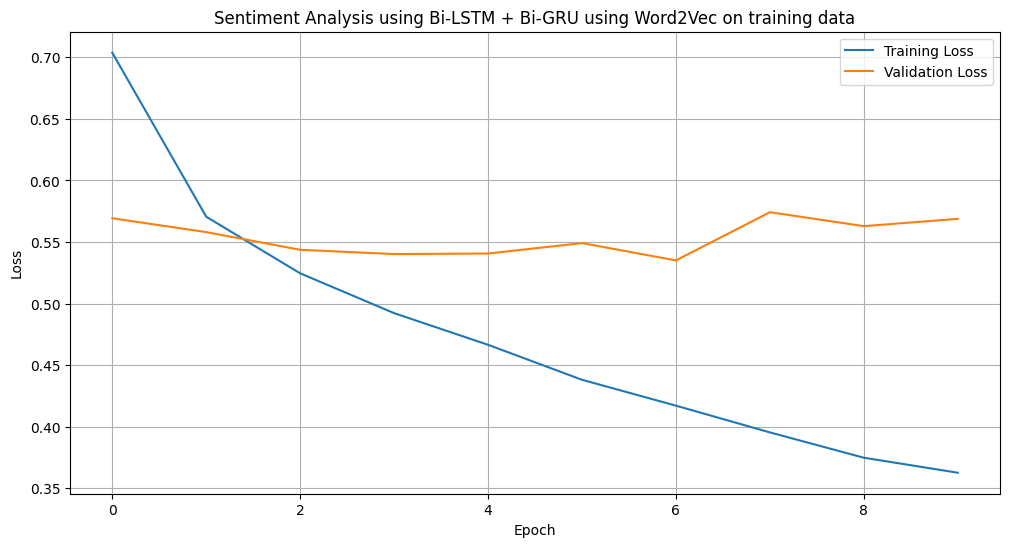

In [55]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Sentiment Analysis using Bi-LSTM + Bi-GRU using Word2Vec on training data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 3.2 Concat Bi-LSTM and Bi-GRU (Word2Vec on the training data)

In [60]:
def LSTM_and_GRU_model():
    input_layer = Input(shape=(128,))
    vocab_size = 12225
    feature = Embedding(input_dim=vocab_size, output_dim=50, input_length=128, weights=[embedding_matrix], embeddings_initializer=GlorotNormal())(input_layer)

    # LSTM layer
    lstm_layer = Bidirectional(LSTM(units=64, dropout=0.2, return_sequences=True, kernel_initializer=GlorotNormal()), merge_mode='concat')(feature)
    lstm_pooling = MaxPooling1D()(lstm_layer)
    lstm_normalized = LayerNormalization()(lstm_pooling)
    lstm_global_max_pool = GlobalMaxPooling1D()(lstm_normalized)

    # GRU layer
    gru_layer = Bidirectional(GRU(units=64, dropout=0.2, return_sequences=True, kernel_initializer=GlorotNormal()), merge_mode='concat')(feature)
    gru_pooling = MaxPooling1D()(gru_layer)
    gru_normalized = LayerNormalization()(gru_pooling)
    gru_global_max_pool = GlobalMaxPooling1D()(gru_normalized)

    combined = Concatenate()([lstm_global_max_pool, gru_global_max_pool])

    # Shared dropout and pooling layers
    shared = Dropout(0.2)(combined)

    # Sentiment Analysis classifier
    sentiment_clf = Dense(128, activation='relu')(shared)
    sentiment_clf = Dropout(0.2)(sentiment_clf)
    sentiment_clf = Dense(64, activation='relu')(sentiment_clf)
    sentiment_clf = Dropout(0.2)(sentiment_clf)
    sentiment_output = Dense(3, activation='softmax', name='sentiment')(sentiment_clf)

    # Model with two outputs
    model = Model(inputs=input_layer, outputs=sentiment_output)

    return model

In [61]:
model = LSTM_and_GRU_model()
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 128, 50)        │        611,250 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 128, 128)       │         58,880 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 128, 128)       │         44,544 │ embedding_1[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 64, 128)        │              0 │ bidirectional_2[0][0]  │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 64, 128)        │              0 │ bidirectional_3[0][0]  │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_2     │ (None, 64, 128)        │            256 │ max_pooling1d_2[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_3     │ (None, 64, 128)        │            256 │ max_pooling1d_3[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_2    │ (None, 128)            │              0 │ layer_normalization_2… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 128)            │              0 │ layer_normalization_3… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 256)            │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         32,896 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)      

 Total params: 756,533 (2.89 MB)

 Trainable params: 756,533 (2.89 MB)

 Non-trainable params: 0 (0.00 B)

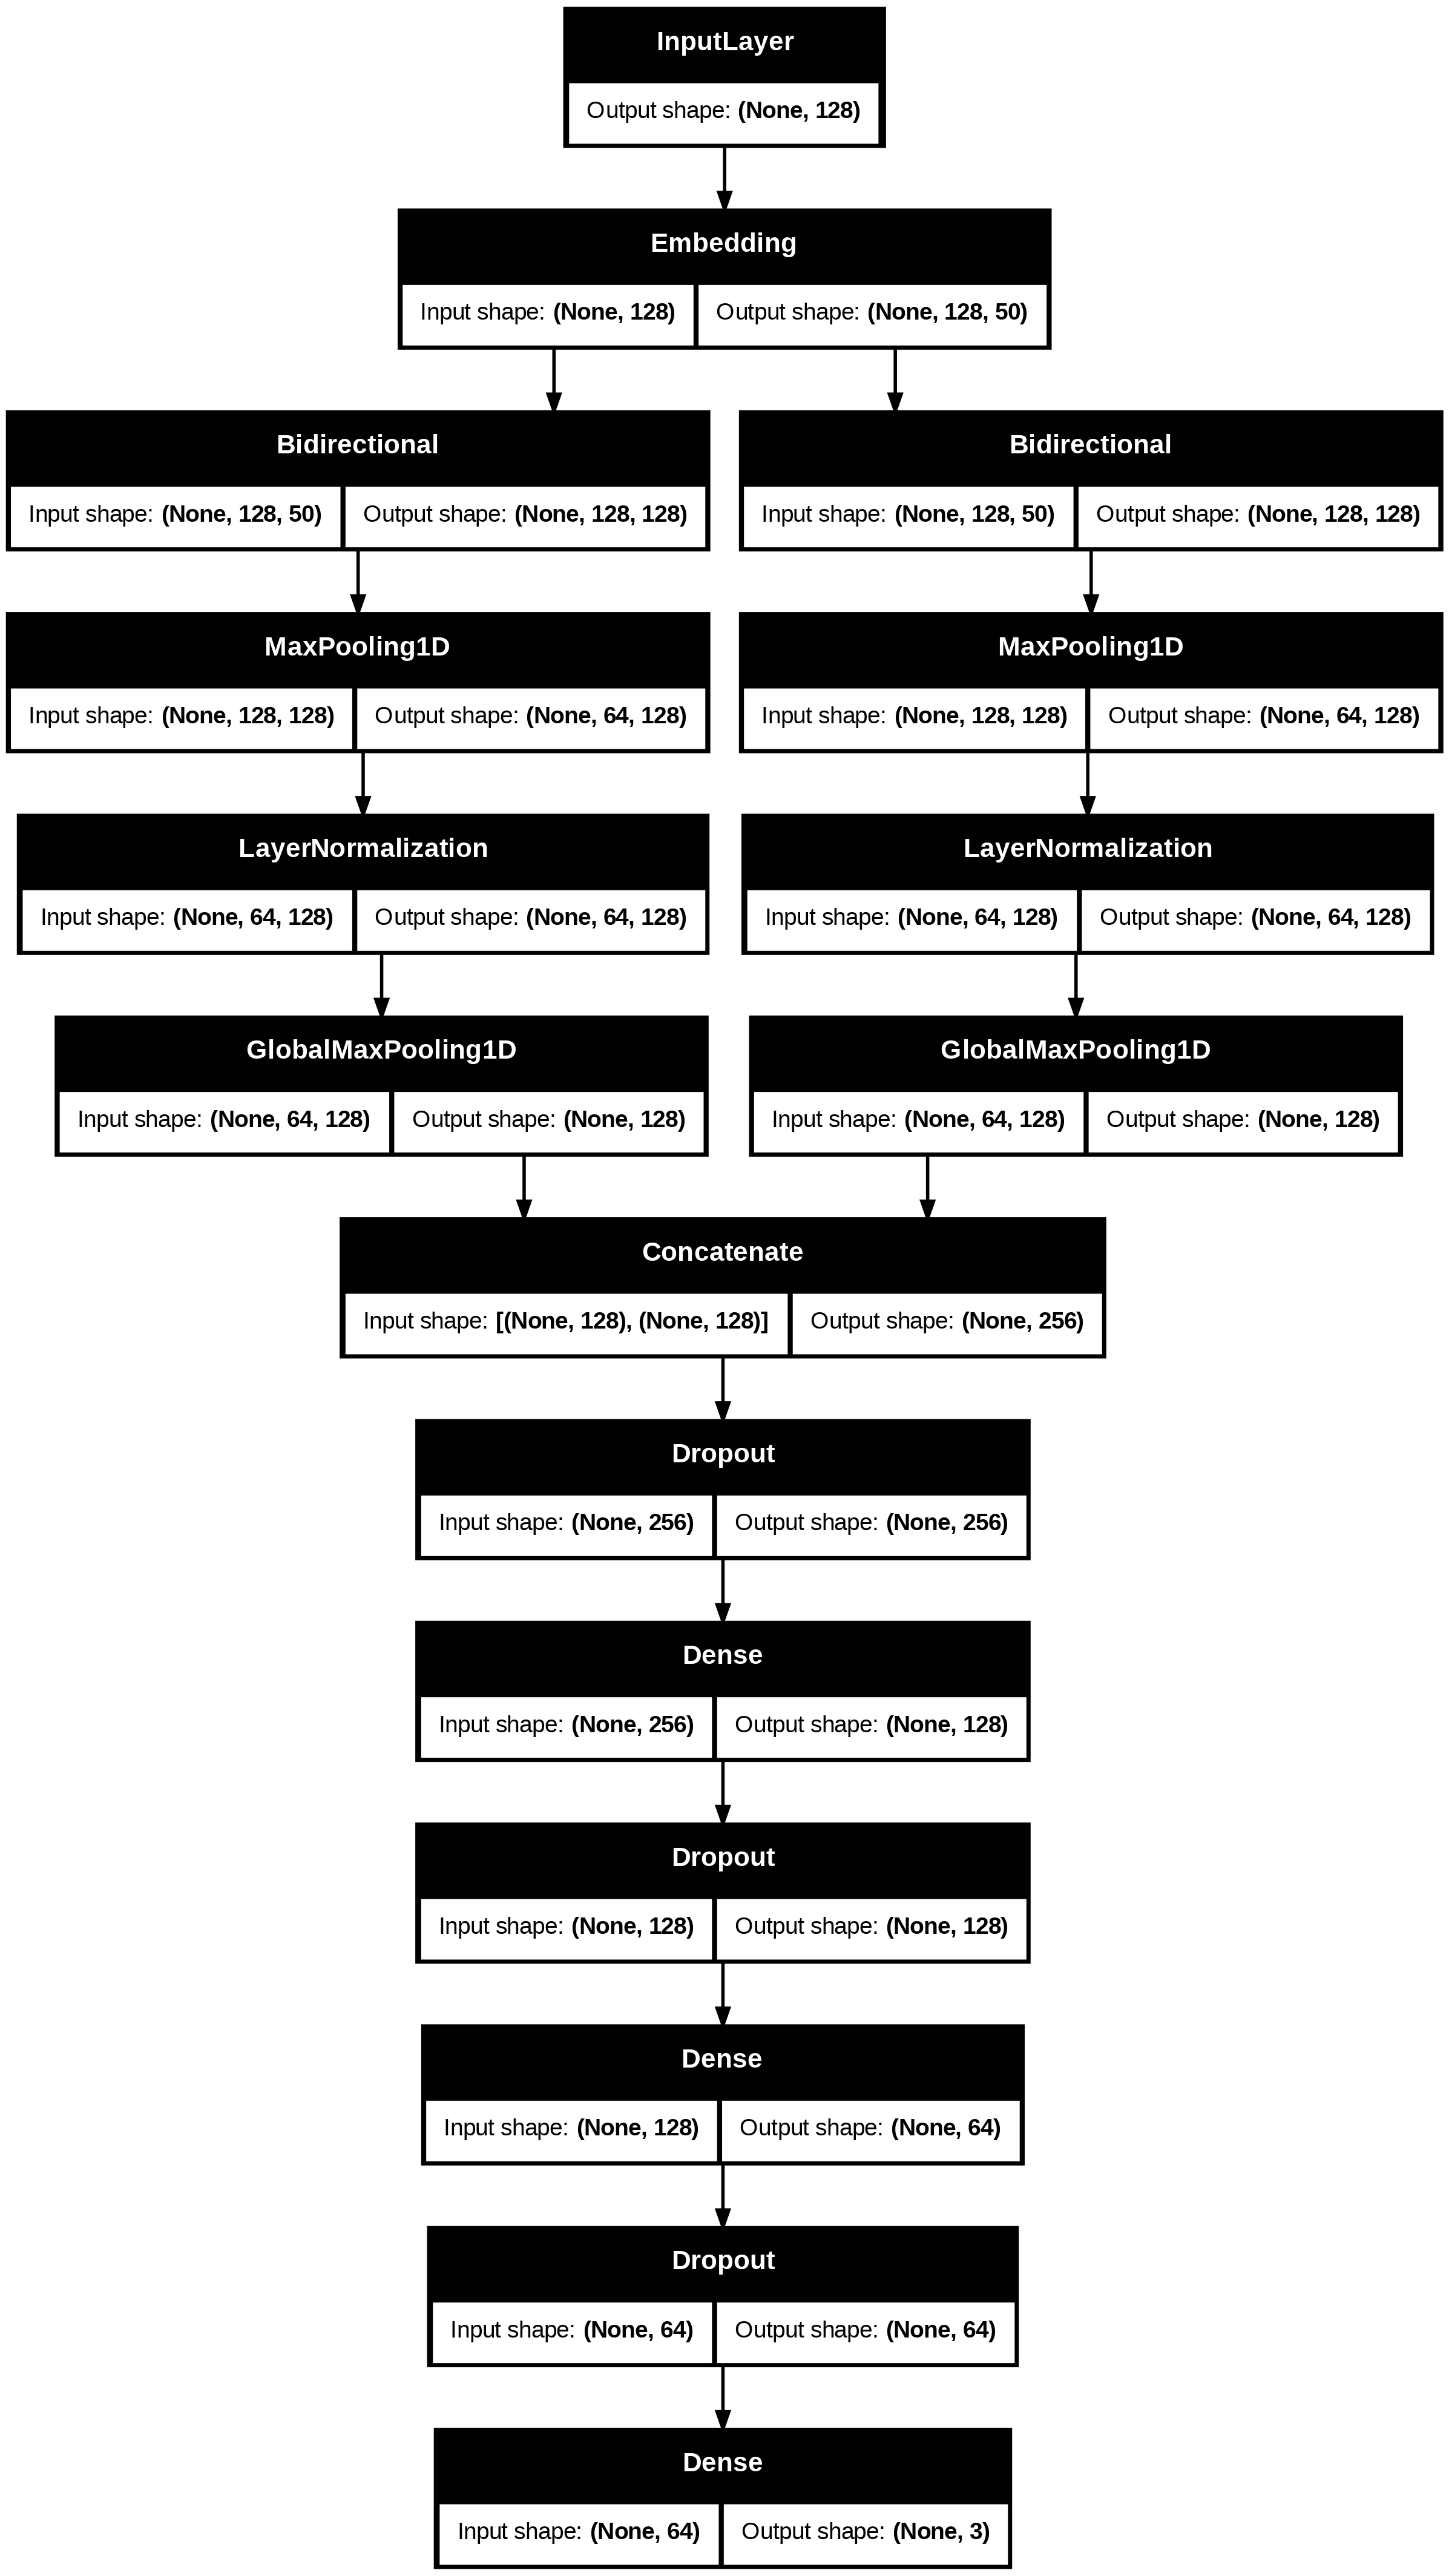

In [62]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [63]:
from keras.callbacks import EarlyStopping

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_padded, train_labels, epochs=25, verbose=1, shuffle=True,
                    validation_data=(val_padded, val_labels), callbacks=[early_stopping])

Epoch 1/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - accuracy: 0.7030 - loss: 0.7479 - val_accuracy: 0.7797 - val_loss: 0.5610
Epoch 2/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 34s 28ms/step - accuracy: 0.7865 - loss: 0.5648 - val_accuracy: 0.7945 - val_loss: 0.5393
Epoch 3/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.7934 - loss: 0.5366 - val_accuracy: 0.7844 - val_loss: 0.5732
Epoch 4/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 42s 30ms/step - accuracy: 0.8046 - loss: 0.5083 - val_accuracy: 0.7963 - val_loss: 0.5288
Epoch 5/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 39s 29ms/step - accuracy: 0.8129 - loss: 0.4867 - val_accuracy: 0.7982 - val_loss: 0.5264
Epoch 6/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 39s 27ms/step - accuracy: 0.8242 - loss: 0.4651 - val_accuracy: 0.7913 - val_loss: 0.5341
Epoch 7/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.8318 - loss: 0.4416 - val_accuracy: 0.7925 - val_loss: 0.5421
Epoch 8/25
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.8400 -

In [64]:
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy is {test_accuracy}")

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7950 - loss: 0.5264
Test Accuracy is 0.7921314239501953


In [65]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Make predictions on test data
predictions = model.predict(test_padded)

# Convert predictions to class labels
predicted_labels = [np.argmax(pred) for pred in predictions]

# Convert true labels to class labels
true_labels = [np.argmax(label) for label in test_labels]

# Generate classification report
report = classification_report(true_labels, predicted_labels)

155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


In [66]:
print(report)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87      3014
           1       0.66      0.41      0.51       933
           2       0.81      0.79      0.80       984

    accuracy                           0.80      4931
   macro avg       0.76      0.71      0.72      4931
weighted avg       0.79      0.80      0.78      4931



In [67]:
from sklearn.metrics import accuracy_score, f1_score

print(f1_score(true_labels, predicted_labels, average = 'weighted'))

0.7848773651245948


In [68]:
from keras.losses import CategoricalCrossentropy

# Calculate categorical cross-entropy loss
loss_fn = CategoricalCrossentropy()
loss = loss_fn(test_labels, predictions).numpy()

print(f"Cross-Entropy Loss: {loss}")

Cross-Entropy Loss: 0.5254713296890259


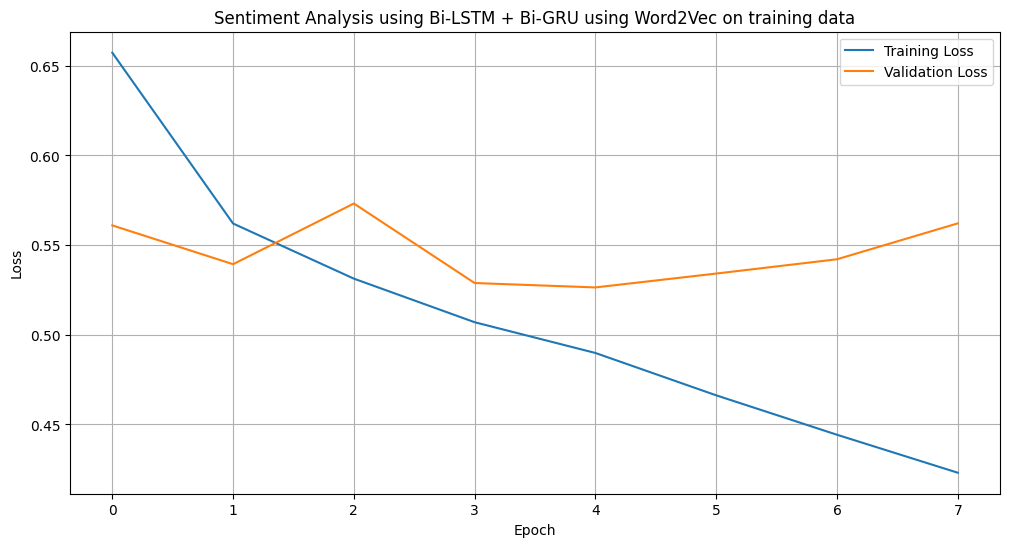

In [69]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Sentiment Analysis using Bi-LSTM + Bi-GRU using Word2Vec on training data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [70]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_labels, predicted_labels)

array([[2775,  136,  103],
       [ 473,  383,   77],
       [ 150,   57,  777]])

In [ ]:
# Save the model to a file
model.save("final-models/Sentiment-Analysis-50dim-28June.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 3.3 Compare Model : Bi-LSTM

In [ ]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, MaxPooling1D, LayerNormalization, Dropout, GlobalMaxPooling1D, Dense, Concatenate
from keras.initializers import GlorotNormal
from keras.models import Model
from keras.optimizers import Adam

def Bi_LSTM_model():
    input_layer = Input(shape=(128,))
    vocab_size = 12225
    feature = Embedding(input_dim=vocab_size, output_dim=50, input_length=128)(input_layer)

    # LSTM layer
    lstm_layer = Bidirectional(LSTM(units=64, dropout=0.2, return_sequences=True), merge_mode='concat')(feature)
    lstm_global_max_pool = GlobalMaxPooling1D()(lstm_layer)
    sentiment_clf = Dropout(0.2)(lstm_global_max_pool)
    sentiment_output = Dense(3, activation='softmax', name='sentiment')(sentiment_clf)

    # Model with two outputs
    model = Model(inputs=input_layer, outputs=sentiment_output)

    return model

In [ ]:
model = Bi_LSTM_model()
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding_6 (Embedding)     (None, 128, 50)           611250    
                                                                 
 bidirectional_5 (Bidirecti  (None, 128, 128)          58880     
 onal)                                                           
                                                                 
 global_max_pooling1d_5 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 sentiment (Dense)           (None, 3)                 387 

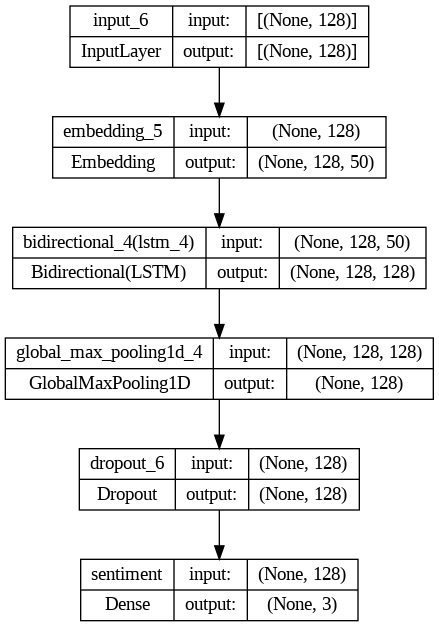

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
from keras.callbacks import EarlyStopping

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_padded, train_labels, epochs=25, verbose=1, shuffle=True,
                    validation_data=(val_padded, val_labels), callbacks=[early_stopping])

Epoch 1/25
1233/1233 [==============================] - 44s 32ms/step - loss: 0.8563 - accuracy: 0.6572 - val_loss: 0.7212 - val_accuracy: 0.7345
Epoch 2/25
1233/1233 [==============================] - 22s 18ms/step - loss: 0.6933 - accuracy: 0.7364 - val_loss: 0.6567 - val_accuracy: 0.7383
Epoch 3/25
1233/1233 [==============================] - 24s 19ms/step - loss: 0.6486 - accuracy: 0.7355 - val_loss: 0.6275 - val_accuracy: 0.7477
Epoch 4/25
1233/1233 [==============================] - 20s 16ms/step - loss: 0.6059 - accuracy: 0.7531 - val_loss: 0.5978 - val_accuracy: 0.7586
Epoch 5/25
1233/1233 [==============================] - 24s 19ms/step - loss: 0.5791 - accuracy: 0.7678 - val_loss: 0.5774 - val_accuracy: 0.7698
Epoch 6/25
1233/1233 [==============================] - 19s 15ms/step - loss: 0.5570 - accuracy: 0.7811 - val_loss: 0.5629 - val_accuracy: 0.7795
Epoch 7/25
1233/1233 [==============================] - 18s 15ms/step - loss: 0.5389 - accuracy: 0.7885 - val_loss: 0.5540 -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print(f"Test Accuracy is {test_accuracy}")

155/155 [==============================] - 2s 10ms/step - loss: 0.5417 - accuracy: 0.7869
Test Accuracy is 0.7868586778640747


In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Make predictions on test data
predictions = model.predict(test_padded)

# Convert predictions to class labels
predicted_labels = [np.argmax(pred) for pred in predictions]

# Convert true labels to class labels
true_labels = [np.argmax(label) for label in test_labels]

# Generate classification report
report = classification_report(true_labels, predicted_labels)

155/155 [==============================] - 2s 6ms/step


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      3014
           1       0.61      0.44      0.52       933
           2       0.84      0.73      0.78       984

    accuracy                           0.79      4931
   macro avg       0.75      0.69      0.72      4931
weighted avg       0.78      0.79      0.78      4931



In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print(f1_score(true_labels, predicted_labels, average = 'weighted'))

0.7769246761909553


In [ ]:
from keras.losses import CategoricalCrossentropy

# Calculate categorical cross-entropy loss
loss_fn = CategoricalCrossentropy()
loss = loss_fn(test_labels, predictions).numpy()

print(f"Cross-Entropy Loss: {loss}")

Cross-Entropy Loss: 0.5416645407676697


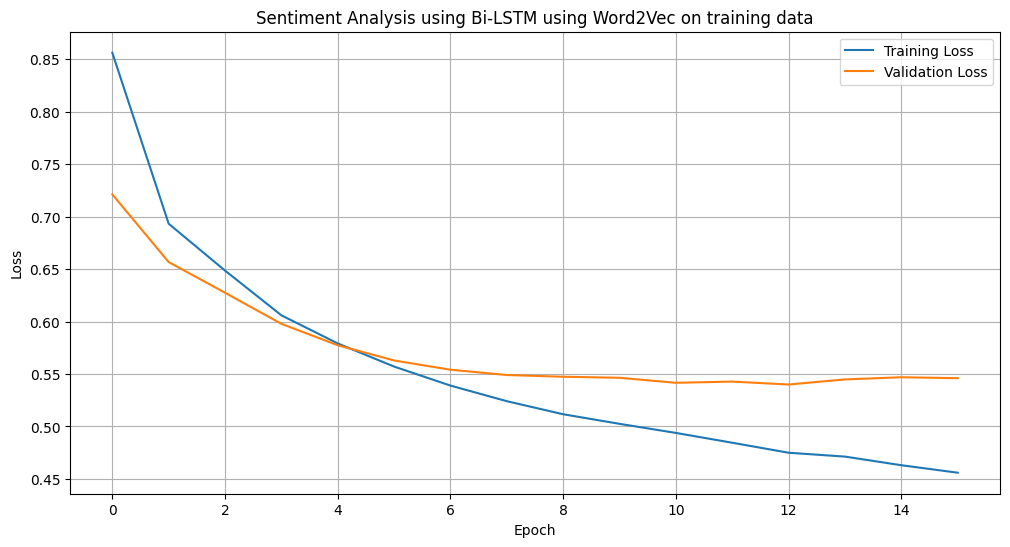

In [ ]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Sentiment Analysis using Bi-LSTM using Word2Vec on training data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Load trained model for testing on new input

Test Instances:

* Tính năng quá tệ, bắt khai báo cccd, đã khai báo rồi chờ 24h không thấy kq cũng không thông báo là được hay không, cứ bắt khai báo quài, lâu lâu thì hệ thông không hỗ trợ kẹt tiền trong tk momo k rút về bank dc rất bực mình (negative)
* Nên tăng cường trải nghiệm người dùng, cụ thể là tốc độ load app, đặc biệt là trên điện thoại thế hệ cũ hay dòng thấp. Tôi đi mua hàng mà đợi momo load xong rồi hiển thị mã qr thanh toán là hết mùa quýt. (neutral)
* Cập nhật mới 2024: app đã rất ổn định. Thanh toán ok với mọi tình huống. Đặc biệt các thanh toán trên cổng Dịch vụ công ổn định hơn so với các ngân hàng. Review đổi từ 1* lên 5* :) 2022: Đến khi thanh toán app chết. Cần ra bản vá gấp. Lỗi khá lâu rồi. Lần sau ko dám nạp nhiều tiền vô MOMO (positive)

In [ ]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model("final-models/Sentiment-Analysis-50dim-28June.h5")

In [71]:
from keras.preprocessing.sequence import pad_sequences

manual_text = "hệ thống này không được tốt, tuy nhiên sử dụng rất tốt "

manual_tokens = tokenizer.texts_to_sequences([manual_text])
manual_padded = pad_sequences(manual_tokens, maxlen=128, padding='post', truncating='post')

# Make predictions
predictions = model.predict(manual_padded)
class_labels = ["Negative", "Neutral", "Positive"]

# Get the predicted class index with the highest probability
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted class: Positive


### 3.4 Compare Model 2: Fine-tuning pre-trained model PhoBert

In [ ]:
!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz

--2024-06-23 12:40:12--  https://public.vinai.io/PhoBERT_base_transformers.tar.gz
Resolving public.vinai.io (public.vinai.io)... 52.84.162.15, 52.84.162.116, 52.84.162.36, ...
Connecting to public.vinai.io (public.vinai.io)|52.84.162.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322405979 (307M) [application/x-tar]
Saving to: ‘PhoBERT_base_transformers.tar.gz’

PhoBERT_base_transf 100%[===================>] 307.47M  23.5MB/s    in 14s     

2024-06-23 12:40:27 (21.7 MB/s) - ‘PhoBERT_base_transformers.tar.gz’ saved [322405979/322405979]

PhoBERT_base_transformers/
PhoBERT_base_transformers/config.json
PhoBERT_base_transformers/bpe.codes
PhoBERT_base_transformers/model.bin
PhoBERT_base_transformers/dict.txt


In [ ]:
!pip install fairseq fastBPE

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 20.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x8

In [ ]:
import os
import torch
import pickle
from tqdm.notebook import tqdm

# from vncorenlp import VnCoreNLP
import argparse
from fairseq.data import Dictionary
from fairseq.data.encoders.fastbpe import fastBPE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score

from keras.preprocessing.sequence import pad_sequences
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load model and BPE
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes',
    default="./PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("./PhoBERT_base_transformers/dict.txt")

In [ ]:
# from transformers import AutoTokenizer, AutoModel
# import torch

# model = AutoModel.from_pretrained("vinai/phobert-base-v2")
# tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [ ]:
max_length = 128

In [ ]:
def convert_sents_ids(sents):
    ids = []
    for sent in sents:
        subwords = '<s> ' + bpe.encode(sent) + ' </s>'
        encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
        ids.append(encoded_sent)
    ids = pad_sequences(ids, maxlen=max_length, dtype="long", value=0, truncating="post", padding="post")
    return torch.tensor(ids)

In [ ]:
lb_encoder = LabelEncoder()
lb_encoder.fit(df_train['label'])

en_train_labels = lb_encoder.transform(df_train['label'])
en_test_labels = lb_encoder.transform(df_test['label'])

print(lb_encoder.classes_)

['Negative' 'Neutral' 'Positive']


In [ ]:
train_sents, val_sents, train_labels, val_labels = train_test_split(df_train['reviews'], en_train_labels, test_size=0.2)
len(train_sents), len(val_sents)

(31555, 7889)

In [ ]:
train_ids = convert_sents_ids(train_sents)
val_ids = convert_sents_ids(val_sents)
test_ids = convert_sents_ids(df_test['reviews'])

In [ ]:
train_ids[0]

tensor([    0,   785,   931,   148,  2821,    57,  2274,    44,  4152,    48,
          219,   127, 10260,    33,  1947,    33,    11,   236,     2,     2,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
for idx in range(len(vocab)):
    word = vocab[idx]
    print(f'Index: {idx}, Word: {word}')

Streaming output truncated to the last 5000 lines.
Index: 59000, Word: ường_trú
Index: 59001, Word: Ỳ@@
Index: 59002, Word: i_trai
Index: 59003, Word: ẻ_tín_dụng
Index: 59004, Word: Tunis@@
Index: 59005, Word: combank
Index: 59006, Word: Veri@@
Index: 59007, Word: SCL
Index: 59008, Word: Bib@@
Index: 59009, Word: Newcastle_@@
Index: 59010, Word: Massachu@@
Index: 59011, Word: _tuyệt
Index: 59012, Word: ®
Index: 59013, Word: Wonder_@@
Index: 59014, Word: Bí_th@@
Index: 59015, Word: Slim_@@
Index: 59016, Word: hanou@@
Index: 59017, Word: kể@@
Index: 59018, Word: Shinji_@@
Index: 59019, Word: chường
Index: 59020, Word: u_riu
Index: 59021, Word: i_trình
Index: 59022, Word: Mallor@@
Index: 59023, Word: chủng_@@
Index: 59024, Word: bên_@@
Index: 59025, Word: vàng_l@@
Index: 59026, Word: Delo@@
Index: 59027, Word: ập_tràn
Index: 59028, Word: Javier@@
Index: 59029, Word: Vietsov@@
Index: 59030, Word: 的@@
Index: 59031, Word: _lớn
Index: 59032, Word: ilbreak
Index: 59033, Word: ng_thế
Index: 590

In [ ]:
print(vocab.indices)

In [ ]:
def make_mask(batch_ids):
    batch_mask = []
    for ids in batch_ids:
        mask = [int(token_id > 0) for token_id in ids]
        batch_mask.append(mask)
    return torch.tensor(batch_mask)

In [ ]:
train_masks = make_mask(train_ids)
val_masks = make_mask(val_ids)
test_masks = make_mask(test_ids)

In [ ]:
train_masks[0]

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
reverse_vocab = {idx: word for word, idx in vocab.indices.items()}

In [ ]:
print(train_ids[10])
print(tokenizer.decode(train_ids[10]))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

def make_data_loader(ids, masks, labels, BATCH_SIZE=32):
    data = TensorDataset(ids, masks, labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=BATCH_SIZE)
    return dataloader

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(en_test_labels)

train_dataloader = make_data_loader(train_ids, train_masks, train_labels)
val_dataloader = make_data_loader(val_ids, val_masks, val_labels)
test_dataloader = make_data_loader(test_ids, test_masks, test_labels)

In [ ]:
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW

config = RobertaConfig.from_pretrained(
    "./PhoBERT_base_transformers/config.json", from_tf=False, num_labels = 3, output_hidden_states=False,
)
PHO_BERT = RobertaForSequenceClassification.from_pretrained(
    "./PhoBERT_base_transformers/model.bin",
    config=config
)

PHO_BERT.cuda()
print('Done')

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./PhoBERT_base_transformers/model.bin and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Done


In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    F1_score = f1_score(pred_flat, labels_flat, average='macro')

    return accuracy_score(pred_flat, labels_flat), F1_score

In [ ]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PHO_BERT.to(device)

# Hyperparameters and optimizer setup
EPOCHS = 10

param_optimizer = list(PHO_BERT.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)

# Tracking variables
TRAIN_ACCURACY, TRAIN_F1, TRAIN_LOSS, VAL_ACCURACY, VAL_F1 = [], [], [], [], []
train_loss_set = []
val_loss_set = []

# Training loop
for epoch_i in range(0, EPOCHS):
    print(f'======== Epoch {epoch_i + 1} / {EPOCHS} ========')
    print('Training...')

    total_loss = 0
    PHO_BERT.train()
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()
        outputs = PHO_BERT(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels)
        loss = outputs.loss
        train_loss_set.append(loss.item())
        total_loss += loss.item()

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        train_f1 += tmp_train_f1
        nb_train_steps += 1

        loss.backward()
        torch.nn.utils.clip_grad_norm_(PHO_BERT.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    TRAIN_LOSS.append(avg_train_loss)
    TRAIN_ACCURACY.append(train_accuracy / nb_train_steps)
    TRAIN_F1.append(train_f1 / nb_train_steps)
    print(f" Accuracy: {train_accuracy / nb_train_steps:.4f}")
    print(f" F1 score: {train_f1 / nb_train_steps:.4f}")
    print(f" Average training loss: {avg_train_loss:.4f}")

    # Validation
    print("Running Validation...")
    PHO_BERT.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0

    for batch in tqdm(val_dataloader, total=len(val_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = PHO_BERT(b_input_ids,
                               token_type_ids=None,
                               attention_mask=b_input_mask,
                               labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits
            eval_loss += loss.item()
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            nb_eval_steps += 1

    avg_val_loss = eval_loss / len(val_dataloader)
    val_loss_set.append(avg_val_loss)
    VAL_ACCURACY.append(eval_accuracy / nb_eval_steps)
    VAL_F1.append(eval_f1 / nb_eval_steps)
    print(f" Accuracy: {eval_accuracy / nb_eval_steps:.4f}")
    print(f" F1 score: {eval_f1 / nb_eval_steps:.4f}")
    print(f" Average validation loss: {avg_val_loss:.4f}")

print("Training complete!")

======== Epoch 1 / 10 ========
Training...


  0%|          | 0/987 [00:00<?, ?it/s]

 Accuracy: 0.7383
 F1 score: 0.5851
 Average training loss: 0.6570
Running Validation...


  0%|          | 0/247 [00:00<?, ?it/s]

 Accuracy: 0.7854
 F1 score: 0.6799
 Average validation loss: 0.5540
======== Epoch 2 / 10 ========
Training...


  0%|          | 0/987 [00:00<?, ?it/s]

 Accuracy: 0.7917
 F1 score: 0.6955
 Average training loss: 0.5387
Running Validation...


  0%|          | 0/247 [00:00<?, ?it/s]

 Accuracy: 0.7901
 F1 score: 0.7017
 Average validation loss: 0.5393
======== Epoch 3 / 10 ========
Training...


  0%|          | 0/987 [00:00<?, ?it/s]

 Accuracy: 0.8128
 F1 score: 0.7317
 Average training loss: 0.4891
Running Validation...


  0%|          | 0/247 [00:00<?, ?it/s]

 Accuracy: 0.7955
 F1 score: 0.7092
 Average validation loss: 0.5266
======== Epoch 4 / 10 ========
Training...


  0%|          | 0/987 [00:00<?, ?it/s]

 Accuracy: 0.8313
 F1 score: 0.7606
 Average training loss: 0.4489
Running Validation...


  0%|          | 0/247 [00:00<?, ?it/s]

 Accuracy: 0.7901
 F1 score: 0.7085
 Average validation loss: 0.5533
======== Epoch 5 / 10 ========
Training...


  0%|          | 0/987 [00:00<?, ?it/s]

 Accuracy: 0.8436
 F1 score: 0.7795
 Average training loss: 0.4145
Running Validation...


  0%|          | 0/247 [00:00<?, ?it/s]

 Accuracy: 0.7907
 F1 score: 0.7062
 Average validation loss: 0.5728
======== Epoch 6 / 10 ========
Training...


  0%|          | 0/987 [00:00<?, ?it/s]

 Accuracy: 0.8617
 F1 score: 0.8061
 Average training loss: 0.3772
Running Validation...


  0%|          | 0/247 [00:00<?, ?it/s]

 Accuracy: 0.7868
 F1 score: 0.7047
 Average validation loss: 0.6079
======== Epoch 7 / 10 ========
Training...


  0%|          | 0/987 [00:00<?, ?it/s]

 Accuracy: 0.8764
 F1 score: 0.8281
 Average training loss: 0.3427
Running Validation...


  0%|          | 0/247 [00:00<?, ?it/s]

 Accuracy: 0.7896
 F1 score: 0.7028
 Average validation loss: 0.6403
======== Epoch 8 / 10 ========
Training...


  0%|          | 0/987 [00:00<?, ?it/s]

 Accuracy: 0.8895
 F1 score: 0.8459
 Average training loss: 0.3094
Running Validation...


  0%|          | 0/247 [00:00<?, ?it/s]

 Accuracy: 0.7864
 F1 score: 0.7014
 Average validation loss: 0.6913
======== Epoch 9 / 10 ========
Training...


  0%|          | 0/987 [00:00<?, ?it/s]

 Accuracy: 0.9016
 F1 score: 0.8639
 Average training loss: 0.2813
Running Validation...


  0%|          | 0/247 [00:00<?, ?it/s]

 Accuracy: 0.7863
 F1 score: 0.7067
 Average validation loss: 0.6970
======== Epoch 10 / 10 ========
Training...


  0%|          | 0/987 [00:00<?, ?it/s]

 Accuracy: 0.9116
 F1 score: 0.8788
 Average training loss: 0.2562
Running Validation...


  0%|          | 0/247 [00:00<?, ?it/s]

 Accuracy: 0.7831
 F1 score: 0.6842
 Average validation loss: 0.8216
Training complete!


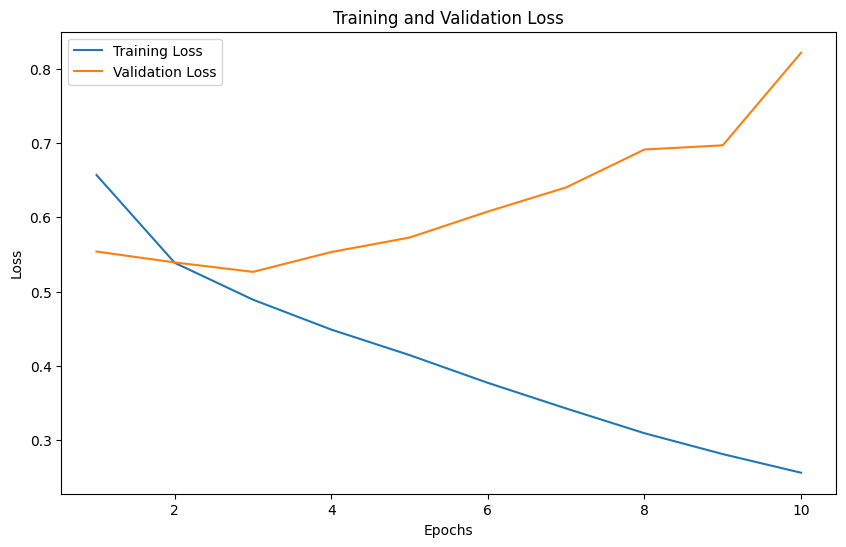

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), TRAIN_LOSS, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_loss_set, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
def test(data_loader):
    PHO_BERT.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    predicts = []
    real_values = []
    for batch in tqdm(data_loader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = PHO_BERT(b_input_ids,
                              token_type_ids=None,
                              attention_mask=b_input_mask)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            predicts.append(np.argmax(logits, axis=1))
            real_values.append(label_ids)
            tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            nb_eval_steps += 1
    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))

    predicts = np.concatenate(predicts)
    real_values = np.concatenate(real_values)

    print('\n', classification_report(real_values, predicts))

In [ ]:
test(test_dataloader)

  0%|          | 0/155 [00:00<?, ?it/s]

 Accuracy: 0.7925
 F1 score: 0.7020

               precision    recall  f1-score   support

           0       0.81      0.92      0.86      3014
           1       0.60      0.42      0.49       933
           2       0.86      0.75      0.80       984

    accuracy                           0.79      4931
   macro avg       0.76      0.70      0.72      4931
weighted avg       0.78      0.79      0.78      4931



In [ ]:
torch.save(PHO_BERT.state_dict(), f'models/phobert_text_classification_23June.pth')

#### Test on new observation

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

model = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [ ]:
# Check if a GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
PHO_BERT = RobertaForSequenceClassification.from_pretrained(
    "./PhoBERT_base_transformers/model.bin",
    config=config
)

PHO_BERT.cuda()

# Load the saved model weights
PHO_BERT.load_state_dict(torch.load('models/phobert_text_classification_19May.pth'))
# Set the model to evaluation mode
PHO_BERT.eval()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./PhoBERT_base_transformers/model.bin and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=0)
      (position_embeddings): Embedding(258, 768, padding_idx=0)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

Test Instances:

* Tính năng quá tệ, bắt khai báo cccd, đã khai báo rồi chờ 24h không thấy kq cũng không thông báo là được hay không, cứ bắt khai báo quài, lâu lâu thì hệ thông không hỗ trợ kẹt tiền trong tk momo k rút về bank dc rất bực mình (negative)
* Nên tăng cường trải nghiệm người dùng, cụ thể là tốc độ load app, đặc biệt là trên điện thoại thế hệ cũ hay dòng thấp. Tôi đi mua hàng mà đợi momo load xong rồi hiển thị mã qr thanh toán là hết mùa quýt. (neutral)
* Cập nhật mới 2024: app đã rất ổn định. Thanh toán ok với mọi tình huống. Đặc biệt các thanh toán trên cổng Dịch vụ công ổn định hơn so với các ngân hàng. Review đổi từ 1* lên 5* :) 2022: Đến khi thanh toán app chết. Cần ra bản vá gấp. Lỗi khá lâu rồi. Lần sau ko dám nạp nhiều tiền vô MOMO (positive)

In [ ]:
# Example new text input
test_input = "Nên tăng cường trải nghiệm người dùng, cụ thể là tốc độ load app, đặc biệt là trên điện thoại thế hệ cũ hay dòng thấp. Tôi đi mua hàng mà đợi momo load xong rồi hiển thị mã qr thanh toán là hết mùa quýt."

# Tokenize the new text input
inputs = tokenizer(test_input, return_tensors='pt', max_length=128, truncation=True, padding='max_length')

# Extract input tensors
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

In [ ]:
# Make the prediction
with torch.no_grad():
    outputs = PHO_BERT(input_ids, attention_mask=attention_mask)

logits = outputs.logits
probabilities = torch.nn.functional.softmax(logits, dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

# Print the predicted class and probabilities
print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities}")

Predicted class: 1
Probabilities: tensor([[0.0711, 0.8728, 0.0561]], device='cuda:0')
